# Tutorial 10 - Advanced Knowledge Tracing

In Lecture 10 (Advanced Student Modelling), you become familiar with a range of extensions of a traditional BKT model, each devoted to solve one or more of its limitations. Specifically, the lecture covered four key strategies: Forgetting (BKT+F), Latent Factor and Knowledge Tracing (LFKT), Feature-Aware Student Knowledge (FAST), and Deep Knowledge Tracing (DKT). 

In this tutorial, you will get hands-on experience on the BKT+F and DKT strategies covered in class to face some of the limitations of the traditional BKT models and improve the model ability of correctly predicting students' knowledge, with a focus on results discuss and interpretation. 

**Learning Objectives**

- Evaluate BKT and BKT + Forgets on different skills and data sets.
- Discuss learning curves for BKT and BKT + Forgets on skills.
- Create and fit a deep knowledge tracing model. 
- Evaluate BKT and Deep BKT on different skills and data sets.
- Run ablation studies on the hyper-parameter of Deep BKT. 
- Discuss learning curves for BKT and DKT on skills.

In [3]:
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc
import json
import math

from pyBKT.models import Model

%matplotlib inline

## 1. Data Sets
---

In [4]:
datasets = {}

### 1.1 Assistments

[2009-2010 ASSISTment Data](https://sites.google.com/site/assistmentsdata/)

Assistments is a data set of 4,217 middle-school students practicing an electronic tutor that teaches and evaluates students in grade-school math, with a total of 525,534 trials. The student data are in a comma-delimited text file with one row per trial. The columns should correspond to a trial's user id, the order id (timestamp), the skill name, and and whether the student produced a correct response in the trial. 

In [5]:
datasets['assistments'] = pd.read_csv('./data/assistments_small.csv', low_memory=False)

In [6]:
datasets['assistments'].head()

,user_id,order_id,skill_name,correct
0,53167,35507211,Scatter Plot,1
1,53167,35507230,Scatter Plot,0
2,53167,35507286,Scatter Plot,1
3,53167,35507293,Scatter Plot,1
4,53167,35507298,Scatter Plot,0


### 1.2 Cognitive Tutor

[Stamper, J., Niculescu-Mizil, A., Ritter, S., Gordon, G.J., & Koedinger, K.R. (2010). Algebra I 2008-2009. Challenge data set from KDD Cup 2010 Educational Data Mining Challenge.](http://pslcdatashop.web.cmu.edu/KDDCup/downloads.jsp)

Cognitive Tutor is a data set of students practicing algebra exercises, with a total of 16,857 trials. The student data are in a space-delimited text file with one row per trial. The student data are in a comma-delimited text file with one row per trial. The columns should correspond to a trial's user id, the order id (timestamp), the skill name, and and whether the student produced a correct response in the trial. 

In [5]:
datasets['cognitivetutor'] = pd.read_csv('./data/cognitivetutor_small.csv', low_memory=False)

In [6]:
datasets['cognitivetutor'].head()

,user_id,order_id,skill_name,correct
0,745Yh,1927,Calculate unit rate,1
1,745Yh,1931,Calculate unit rate,0
2,745Yh,1947,Calculate unit rate,0
3,745Yh,1948,Calculate unit rate,1
4,745Yh,1963,Calculate unit rate,0


### 1.3 Data Set Summary

In [7]:
lst = []

for name, data in datasets.items():
    lst.append([name, len(data['user_id'].unique()), len(data.index), len(data['skill_name'].unique())])
    
pd.DataFrame(lst, columns=['Dataset Name', 'Students', 'Observations', 'Skills'])

,Dataset Name,Students,Observations,Skills
0,assistments,577,7825,3
1,cognitivetutor,478,11599,3


## 2. Comparing BKT and BKT+F

[Mohammad Khajah, Robert V. Lindsey, Michael Mozer: How Deep is Knowledge Tracing? EDM 2016.](https://www.educationaldatamining.org/EDM2016/proceedings/paper_144.pdf) 

To capture recency effects, BKT can be extended to allow skill forgetting. Forgetting corresponds to fitting a BKT parameter $F ≡ P(K_{s,i+1} = 0 | K_{si} = 1)$, the probability of transitioning from a state of knowing to not knowing a skill. In standard BKT, $F = 0$. Without forgetting, once BKT infers that the student has learned, even a long run of poorly performing trials cannot alter the inferred knowledge state. However, with forgetting, the knowledge state can transition in either direction, which allows the model to be more sensitive to the recent trials: a run of unsuccessful trials is indicative of not knowing the skill. 

Forgetting is not a new idea to BKT, and in fact was included in the original psychological theory that underlies the notion of binary knowledge state. However, it has not typically been incorporated into BKT. When it has been included in BKT, the motivation was to model forgetting from one day to the next, not forgetting that can occur on a much shorter time scale. Incorporating forgetting can not only sensitize BKT to recent events but can also contextualize trial sequences. Using forgetting, BKT can readily incorporate some information about the absolute trial sequence, and therefore has more potential than classic BKT to be sensitive to interspersed trials in the exercise sequence. 

### 2.1 Experimental Pipeline Definition

We create an iterator able to user-stratify the interactions typical in a knowledge tracing data set. 

In [8]:
def create_iterator(data):
    X = np.arange(len(data.index)) 
    groups = data['user_id'].values 
    return GroupKFold(n_splits=10).split(X, groups=groups)

We then use the iterator to implement a cross validation across the data set {name} with interactions in {data} for a BKT model whose forgetting flag is defined by the {forgets} parameters. At each iteration, each model is evaluated on the Area Under the ROC Curve (AUC) and the Root Mean Squared Error (RMSE). AUC is a measure ranging from 0 to 1, with 0.5 reflecting no ability to distinguish correct from incorrect responses and 1.0 reflecting perfect ability. RMSE is a non-negative error measure, with 0 reflecting the perfect ability to distinguish correct from incorrect responses, and scores higher than 0 reflecting weaknesses in this ability. Both RMSE and AUC are computed by obtaining a prediction on the test set, across all skills, and then using the complete set of predictions. 

In [9]:
def cross_validate(name, data, forgets):
    ### BEGIN SOLUTION
    skills = data['skill_name'].unique()
    rmse, auc = [], []
    print('Evaluating BKT model with forgets={} on the {} data set with skills={}'.format(forgets, name, skills))
    for iteration, (train_index, test_index) in enumerate(create_iterator(data)):
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        model = Model(seed=0)
        %time model.fit(data=X_train, forgets=forgets) 
        rmse.append(model.evaluate(data=X_test, metric='rmse'))
        auc.append(model.evaluate(data=X_test, metric='auc'))
        print('>  Iteration:', iteration, 'RMSE', rmse[-1], 'AUC', auc[-1])
    ### END SOLUTION
    return {'rmse': rmse, 'auc': auc}

### 2.2 Overall Evaluation

We define the path where the performance metrics results for each data set will be saved, due to the time-consuming process involving learning a BKT and a BKT+F model. In what follows, we provide you with the code to fit a BKT model, but we will use the already computed results during the lab session due to time constraints - we are more interested in the final discussion.  

For each data set, we run the cross-validation evaluation method, saving AUC and RMSE at each iteration. 

In [ ]:
### BEGIN SOLUTION
overall_results = {}
for name, data in datasets.items():
    overall_results[name] = {'BKT': cross_validate(name, data, False), 'BKT+F': cross_validate(name, data, True)} 
### END SOLUTION

We then store the results on the disk for future usage. 

In [28]:
def save_results(filename, results):
    with open(filename, 'w') as fp:
        json.dump(results, fp, sort_keys=True, indent=4)

In [16]:
save_results('./results/overall_performance.json', overall_results)

The results can be also loaded from an already saved file. 

In [11]:
def load_results(filename):
    with open(filename, 'r') as fp:
        results = json.load(fp)
    return results

In [14]:
overall_results = load_results('./results/overall_performance.json')

For both data sets, we plot the AUC and RMSE scores obtained by the BKT and BKT+F models. What is the impact of forgetting in the final performance? To what extent does this impact change across data sets? What conclusions can we make?

In [19]:
def plot_overall_results(results):
    ### BEGIN SOLUTION
    no_datasets = len(results.keys())
    
    plt.figure(figsize=(12, 4 * no_datasets))
    
    for d_idx, (dataset, models) in enumerate(results.items()):
        
        plt.suptitle(dataset)
        
        plt.subplot(d_idx + 1, 2, 1)
        plt.title('AUC')
        df_metric = pd.DataFrame({'BKT': models['BKT']['auc'], 'BKT+F': models['BKT+F']['auc']})
        sns.boxplot(x='variable', y='value', data=pd.melt(df_metric))
        plt.ylabel('AUC')
        plt.xlabel('Model')
        
        plt.subplot(d_idx + 1, 2, 2)
        plt.title('RMSE')
        df_metric = pd.DataFrame({'BKT': models['BKT']['rmse'], 'BKT+F': models['BKT+F']['rmse']})
        sns.boxplot(x='variable', y='value', data=pd.melt(df_metric))
        plt.ylabel('RMSE')
        plt.xlabel('Model')

    plt.tight_layout()
    plt.show()
    ### END SOLUTION

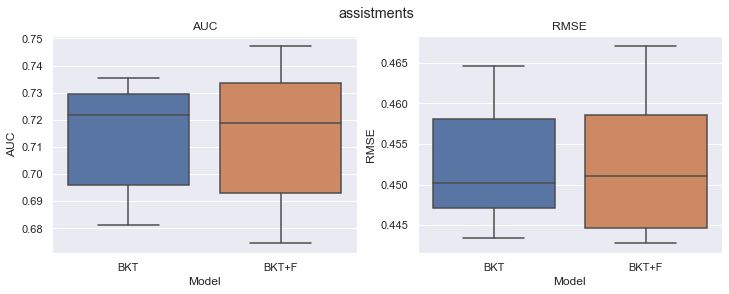

In [20]:
plot_overall_results(overall_results)

### 2.3 Skill-level Evaluation

Unfortunately, the overall performance does not tell us much about the there are discrepancies across skills. To what extent the performance varies across skills and data sets? How does this differ from the results in the overall evaluation? Is there more agreement or less between the different metrics in this and the latter setting? This evaluation can shed light on skills that need further investigation due to lower performance. 

We run a similar pipeline. The only change is related to an additional loop along skills. 

In [ ]:
### BEGIN SOLUTION
skill_results = {}
for name, data in datasets.items():
    skill_results[name] = {}
    for skill in data['skill_name'].unique():
        sdata = data[data['skill_name'] == skill]
        skill_results[name][skill] = {'BKT':cross_validate(name, sdata, False), 'BKT+F':cross_validate(name, sdata, True)} 
### END SOLUTION

In [29]:
save_results('./results/skill_performance.json', skill_results)

Once the results are computed, we can load and show them appropriately. 

In [ ]:
skill_results = load_results('./results/skill_performance.json')

Finally, we plot it. 

In [53]:
def plot_skill_results(results):
    ### BEGIN SOLUTION
    no_datasets = len(results.keys())
    
    plt.figure(figsize=(20, 10 * no_datasets))
    
    for d_idx, (dataset, skills) in enumerate(results.items()):
        
        plt.suptitle(dataset)
        
        for s_idx, (skill, skill_data) in enumerate(skills.items()):
            plt.subplot(2 * no_datasets, len(skills.keys()), s_idx + 1)
            plt.title(skill)
            df_metric = pd.DataFrame({'BKT': skill_data['BKT']['auc'], 'BKT+F': skill_data['BKT+F']['auc']})
            sns.boxplot(x='variable', y='value', data=pd.melt(df_metric))
            plt.ylabel('AUC')
            plt.ylim(0.5, 0.9)
            plt.xlabel('Model')
        
        for s_idx, (skill, skill_data) in enumerate(skills.items()):
            plt.subplot(2 * no_datasets, len(skills.keys()), len(skills.keys()) + s_idx + 1)
            plt.title(skill)
            df_metric = pd.DataFrame({'BKT': skill_data['BKT']['rmse'], 'BKT+F': skill_data['BKT+F']['rmse']})
            sns.boxplot(x='variable', y='value', data=pd.melt(df_metric))
            plt.ylabel('RMSE')
            plt.ylim(0.25, 0.50)
            plt.xlabel('Model')

    plt.tight_layout()
    plt.show()
    ### END SOLUTION

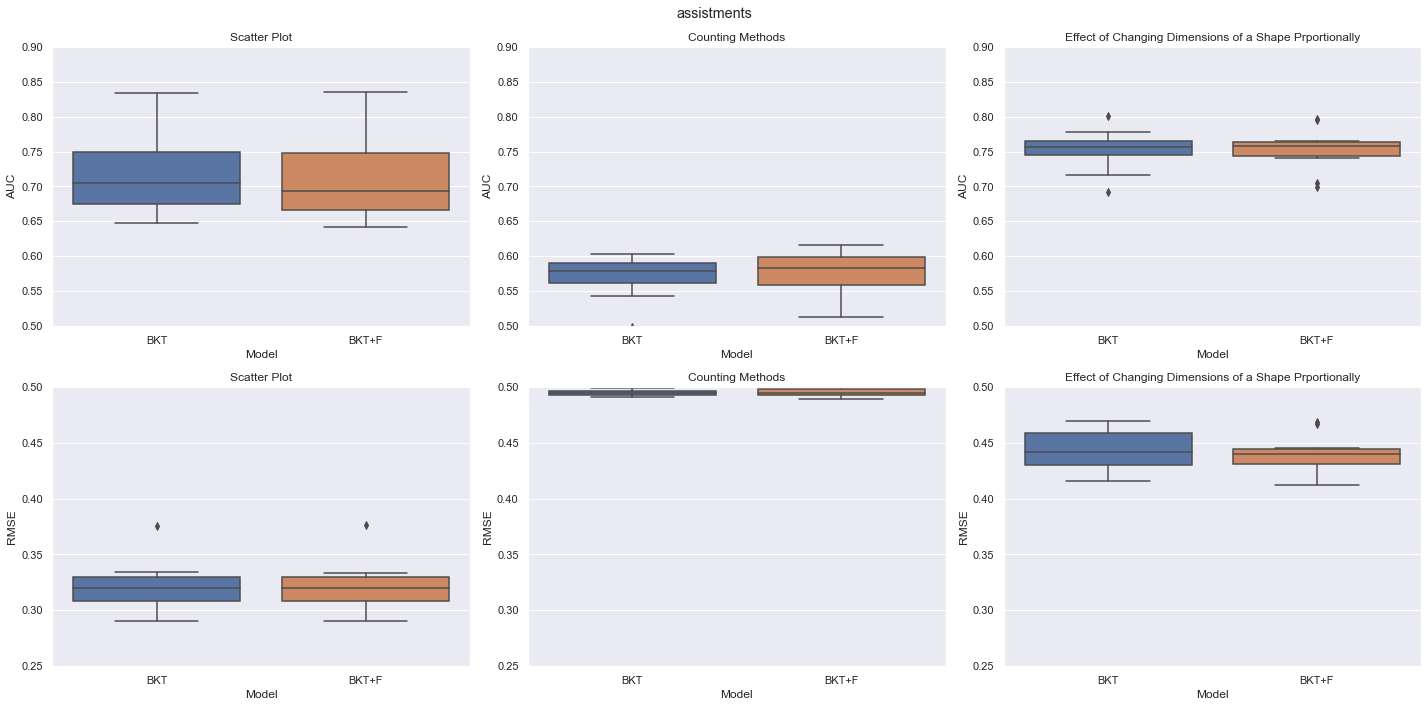

In [54]:
plot_skill_results(skill_results)

### 2.4 Learning Curve Evaluation

Another important aspect that require investigation is the extent to which forgetting impacts on the approximation of the learning curve. How does BKT+F differ from BKT in terms of learning curve? Does BKT+F over or underestimate student's errors? Is the behavior consistent along the opportunities? Plotting the learning curves for the two models will help us answer these questions.  

In [ ]:
sel_dataset = 'assistments'

We first fit and predict on the full data set for a BKT and a BKT+F model. 

In [56]:
predictions = {}

In [57]:
### BEGIN SOLUTION
model = Model(seed=0)
%time model.fit(data=data)
predictions[sel_dataset] = model.predict(data=data)[['user_id', 'skill_name','correct', 'correct_predictions']]
predictions[sel_dataset] = predictions[name].rename({'correct':'y_true', 'correct_predictions': 'y_pred_bkt'}, axis=1)
    
model = Model(seed=0)
%time model.fit(data=data, forgets=True)
predictions[sel_dataset]['y_pred_bkt+f'] = model.predict(data=data)['correct_predictions']
### END SOLUTION

Wall time: 5min 48s
Wall time: 12min 44s


In [60]:
predictions[sel_dataset].to_csv('./results/skill_predictions.json', index=False)

If you want to experiment with already computed results, you can directly load them. 

In [61]:
predictions[sel_dataset] = pd.read_csv('./results/skill_predictions.json')

In [63]:
predictions[sel_dataset].head()

,user_id,skill_name,y_true,y_pred_bkt,y_pred_bkt+f
0,53167,Scatter Plot,1,0.74249,0.74555
1,53167,Scatter Plot,0,0.89486,0.91183
2,53167,Scatter Plot,1,0.75499,0.78393
3,53167,Scatter Plot,1,0.89899,0.91880
4,53167,Scatter Plot,0,0.93824,0.93866


We then re-use the utility functions to plot the learning curves. 

In [64]:
def avg_y_by_x(x, y):
    x = np.array(x)
    y = np.array(y)

    xs = sorted(list(set(x)))
    
    xv, yv, lcb, ucb, n_obs = [], [], [], [], []
    for v in xs:
        ys = [y[i] for i, e in enumerate(x) if e == v] 
        if len(ys) > 0: 
            xv.append(v) 
            yv.append(sum(ys) / len(ys))
            n_obs.append(len(ys)) 
        
            unique, counts = np.unique(ys, return_counts=True)
            counts = dict(zip(unique, counts))

            if 0 not in counts:
                counts[0] = 0
            if 1 not in counts:
                counts[1] = 0

            ci = sc.stats.beta.interval(0.95, 0.5 + counts[0], 0.5 + counts[1])
            lcb.append(ci[0])
            ucb.append(ci[1])

    return xv, yv, lcb, ucb, n_obs

In [76]:
def plot_learning_curves(predictions):
    for plot_id, skill_name in enumerate(predictions['skill_name'].unique()):

        preds = predictions[predictions['skill_name'] == skill_name] 

        xp = []
        yp = {}
        for col in preds.columns:
            if 'y_' in col:
                yp[col] = []

        for user_id in preds['user_id'].unique(): 
            user_preds = preds[preds['user_id'] == user_id] 
            xp += list(np.arange(len(user_preds)))
            for col in preds.columns: 
                if 'y_' in col: 
                    yp[col] += user_preds[col].tolist() 

        fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}) 

        lines = []
        for col in preds.columns:
            if 'y_' in col: 
                x, y, lcb, ucb, n_obs = avg_y_by_x(xp, yp[col])  
                y = [1-v for v in y]
                if col == 'y_true': 
                    axs[0].fill_between(x, lcb, ucb, alpha=.1)
                model_line, = axs[0].plot(x, y, label=col) 
                lines.append(model_line) 

        axs[0].set_title(skill_name)
        axs[0].legend(handles=lines)
        axs[0].set_ylabel('Error')
        axs[0].set_ylim(0, 1)
        axs[0].set_xlim(0, None)

        axs[1].set_xlabel('#Opportunities')
        axs[1].bar([i for i in range(len(n_obs))], n_obs)
        axs[1].set_ylabel('#Observations')
        axs[1].set_ylim(0, 750)
        axs[1].set_xlim(0, None)

        plt.tight_layout()
        plt.show()

Finally, we plot the learning curves. 

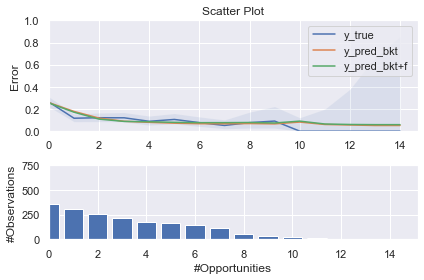

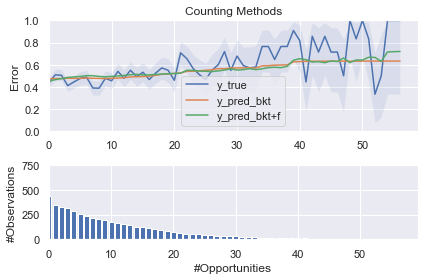

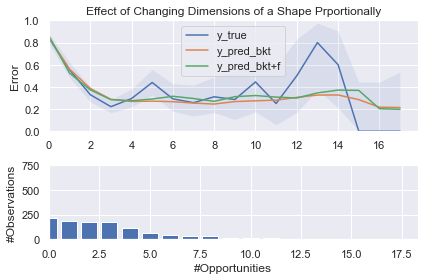

In [77]:
### BEGIN SOLUTION
plot_learning_curves(predictions[sel_dataset])
### END SOLUTION

## 3. BKT and DKT

Knowledge tracing is one of the key research areas for empowering personalized education. It is a task to model students' mastery level of a skill based on their historical learning trajectories. In recent years, a recurrent neural network model called deep knowledge tracing (DKT) has been proposed to handle the knowledge tracing task and literature has shown that DKT generally outperforms traditional methods.

In this lab session, we will create and evaluate DKT models on top of a TensorFlow framework. For those who are not familiar with this framework, we recommended to follow the [official tutorials](https://www.tensorflow.org/tutorials/quickstart/beginner). 

To give more date to the DKT to learn from, we will use the extended version of the assistments data set.   

In [11]:
dataset = pd.read_csv('./data/assistments.csv', low_memory=False)

In [12]:
len(dataset.index), len(dataset['skill_name'].unique()), len(dataset['user_id'].unique())

(525534, 111, 4217)

### 3.1 Data Preparation

As presented in the lecture, a DKT model is characterized by the following main three components:
- **Input**: the one-hot encoded observations at varying time steps. 
- **Network**: a recurrent neural network that processes the one-hot encoded observations in a time-wise manner. 
- **Output**: the probabilities for answering skill (or item) correct at the varying time steps.  

The first step to enable a DKT experimental pipeline requires to prepare the input and output data to be fed into the model during the training and evaluation phases. TensorFlow has an API, called [TF Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), that supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern: (i) create a source dataset from your input data, (ii) apply dataset transformations to preprocess the data, (iii) iterate over the dataset and process the elements. Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

In [13]:
def prepare_data(df, params):
    # Step 1 - Enumerate skill id
    df['skill'], skill_codes = pd.factorize(df['skill_name'], sort=True)

    # Step 2 - Cross skill id with answer to form a synthetic feature
    df['skill_with_answer'] = df['skill'] * 2 + df['correct']

    # Step 3 - Convert to a sequence per user id and shift features 1 timestep
    seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values[:-1], r['skill'].values[1:], r['correct'].values[1:],))
    
    # Step 4 - Get Tensorflow Dataset
    dataset = tf.data.Dataset.from_generator(generator=lambda: seq, output_types=(tf.int32, tf.int32, tf.float32))

    # Step 5 - Encode categorical features and merge skills with labels to compute target loss.
    features_depth = df['skill_with_answer'].max() + 1
    skill_depth = df['skill'].max() 

    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(values=[tf.one_hot(skill, depth=skill_depth), tf.expand_dims(label, -1)], axis=-1)
        )
    )

    # Step 6 - Pad sequences per batch
    dataset = dataset.padded_batch(
        batch_size=params['batch_size'],
        padding_values=(params['mask_value'], params['mask_value']),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=True
    )

    return dataset.repeat(), len(seq), features_depth, skill_depth, skill_codes

The data needs to be fed into the model in batches. Therefore, we need to specify in advance how many elements per batch our DKT will receive. Furthermore, all sequences should be of the same length in order to be fed into the model. Given that students have different number of opportunities across skills, we need to define a masking value for those entries that are introduced as a padding into the student's sequences. 

In [14]:
params = {}
params['batch_size'] = 32
params['mask_value'] = -1.0

Let's see an example of how the TF Dataset API works. We will create the Dataset instance and take 10 examples. To understand how things are going, we will prepare the smaller version of assistments just for this example.  

In [15]:
tf_dataset, length, nb_features, nb_skills, skill_codes = prepare_data(datasets['assistments'].copy(), params)

We will take the first 10 batches and pront the shapes. What does each tuple represent? What does each dimension represent for each tuple? Why does the second dimension of each tuple differ? 

In [17]:
for rank, (x, y) in enumerate(tf_dataset.take(10)):
    print(rank, x.shape, y.shape)

0 (32, 45, 6) (32, 45, 3)
1 (32, 54, 6) (32, 54, 3)
2 (32, 64, 6) (32, 64, 3)
3 (32, 76, 6) (32, 76, 3)
4 (32, 31, 6) (32, 31, 3)
5 (32, 33, 6) (32, 33, 3)
6 (32, 10, 6) (32, 10, 3)
7 (32, 15, 6) (32, 15, 3)
8 (32, 13, 6) (32, 13, 3)
9 (32, 19, 6) (32, 19, 3)


To understand how the data has been encoded, let's print the integer codes for the skills and the first lines of the original data set. 

In [18]:
[(i, v) for i, v in enumerate(skill_codes.tolist()) if v == 'Scatter Plot']

[(2, 'Scatter Plot')]

In [19]:
datasets['assistments'].head()

,user_id,order_id,skill_name,correct
0,53167,35507211,Scatter Plot,1
1,53167,35507230,Scatter Plot,0
2,53167,35507286,Scatter Plot,1
3,53167,35507293,Scatter Plot,1
4,53167,35507298,Scatter Plot,0


...and show the values for the first element of the first batch. How does this representation map to the original dataframe?

In [20]:
for rank, (i, element) in enumerate(tf_dataset.take(1)):
    print(i)

tf.Tensor(
[[[ 0.  0.  0.  0.  0.  1.]
  [ 0.  0.  0.  0.  1.  0.]
  [ 0.  0.  0.  0.  0.  1.]
  ...
  [-1. -1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1. -1.]]

 [[ 0.  0.  0.  0.  0.  1.]
  [ 0.  0.  0.  0.  0.  1.]
  [ 0.  1.  0.  0.  0.  0.]
  ...
  [-1. -1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1. -1.]]

 [[ 0.  0.  0.  0.  0.  1.]
  [-1. -1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1. -1.]
  ...
  [-1. -1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1. -1.]]

 ...

 [[ 1.  0.  0.  0.  0.  0.]
  [-1. -1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1. -1.]
  ...
  [-1. -1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1. -1.]]

 [[ 1.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.]
  [ 0.  1.  0.  0.  0.  0.]
  ...
  [-1. -1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1. -1.]
  [-1. -1. -1. -1. -1. -1.]]

 [[ 0.  0.  1.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.  0.]
  [-1. -1. -1. -1. -1. -1.]
  ...
  [-1. -1. -1

### 3.2 Data Split

Once our data has been pre-processed, it is time to perform the train-test split - please note that, in this part of the tutorial, we do not adopt a cross-validation evaluation method due to the time constraints. Given that the neural network training requires multiple epochs, we will monitor performance metrics after each epoch on a validation set. Therefore, the split actually includes train-validation-test sets, as follows. 

In [21]:
def split_dataset(dataset, params):
    def split(dataset, split_size):
        split_set = dataset.take(split_size)
        dataset = dataset.skip(split_size)
        return dataset, split_set

    test_size = np.ceil(params['test_ratio'] * params['total_size'])
    train_size = params['total_size'] - test_size

    train_set, test_set = split(dataset, test_size)

    val_set = None
    if params['val_ratio'] > 0:
        val_size = np.ceil(train_size * params['val_ratio'])
        train_set, val_set = split(train_set, val_size)
        train_size -= val_size
        
    return train_set, train_size, test_set, test_size, val_set, val_size

We instantiate our TF Dataset. 

In [22]:
tf_dataset, length, nb_features, nb_skills, skill_codes = prepare_data(dataset, params)

We then add the total size of the dataset, the test ratio, and the validation ratio to our dictionary of parameters.  

In [23]:
params['total_size'] = int(length // params['batch_size'])
params['test_ratio'] = 0.2
params['val_ratio'] = 0.2

Finally, we perform the split.

In [24]:
train_set, train_size, test_set, test_size, val_set, val_size = split_dataset(tf_dataset, params)

This is a summary of the data we will fed into the DKT model. 

In [25]:
print('Total number of students (batches): {}'.format(train_size + val_size + test_size))
print('Training set size (batches): {}'.format(train_size))
print('Validation set size (batches): {}'.format(val_size))
print('Testing set size (batches): {}'.format(test_size))
print('Number of skills (batches): {}'.format(nb_skills))
print('Number of features in the input (batches): {}'.format(nb_features))

Total number of students (batches): 131.0
Training set size (batches): 83.0
Validation set size (batches): 21.0
Testing set size (batches): 27.0
Number of skills (batches): 109
Number of features in the input (batches): 220


In [270]:
params['verbose'] = 1 # Verbose = {0,1,2}
params['best_model_weights'] = 'weights/bestmodel' # File to save the model
params['optimizer'] = 'adam' # Optimizer to use
params['backbone_nn'] = tf.keras.layers.LSTM # Backbone neural network
params['recurrent_units'] = 64 # Number of LSTM units
params['epochs'] = 10 # Number of epochs to train
params['dropout_rate'] = 0.3 # Dropout rate

Considering that we padded the sequences such that all have the same length, we need to remove predictions on the time step associated with padding. To this end, we implement a function calle get_target. 

In [271]:
def get_target(y_true, y_pred, mask_value=params['mask_value']):
    
    # Get skills and labels from y_true
    mask = 1. - tf.cast(tf.equal(y_true, mask_value), y_true.dtype)
    y_true = y_true * mask

    skills, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    # Get predictions for each skill
    y_pred = tf.reduce_sum(y_pred * skills, axis=-1, keepdims=True)

    return y_true, y_pred

While training and evaluating the model, we will monitor the following performance metrics: binary accuracy, AUC, precision, and recall. Please, note that we need to process our targets before using the default TensorFlow metric functions. 

In [272]:
class BinaryAccuracy(tf.keras.metrics.BinaryAccuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(BinaryAccuracy, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

class AUC(tf.keras.metrics.AUC):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(AUC, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

class Precision(tf.keras.metrics.Precision):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(Precision, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

class Recall(tf.keras.metrics.Recall):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(Recall, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

Same discourse for the loss. As we have seen in the lecture, we need to use a binary crossentropy function to compute the loss the model makes in predicting the labels. Please, note that we need to use the get_target function in this case too. 

In [273]:
def CustomBinaryCrossEntropy(y_true, y_pred):    
    y_true, y_pred = get_target(y_true, y_pred)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

Now, we can create the DKT architecture using the TensorFlow functional API. 

In [274]:
def create_model(nb_features, nb_skills, params):
    
    # Create the model architecture
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')
    x = tf.keras.layers.Masking(mask_value=params['mask_value'])(inputs)
    x = params['backbone_nn'](params['recurrent_units'], return_sequences=True, dropout=params['dropout_rate'])(x)
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
    outputs = tf.keras.layers.TimeDistributed(dense, name='outputs')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='DKT')

    # Compile the model
    model.compile(loss=CustomBinaryCrossEntropy, 
                  optimizer=params['optimizer'], 
                  metrics=[BinaryAccuracy(), AUC(), Precision(), Recall()])
    
    return model

In [275]:
model = create_model(nb_features, nb_skills, params)

Finally, we show a table summary of the DKT model architecture. 

In [276]:
model.summary()

Model: "DKT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 220)]       0         
_________________________________________________________________
masking_5 (Masking)          (None, None, 220)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          72960     
_________________________________________________________________
outputs (TimeDistributed)    (None, None, 110)         7150      
Total params: 80,110
Trainable params: 80,110
Non-trainable params: 0
_________________________________________________________________


### 3.4 Model Fitting

The data and the model have been prepared and now we can proceed with the model fitting stage. 

In [277]:
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], save_best_only=True, save_weights_only=True)

history = model.fit(train_set, epochs=params['epochs'], steps_per_epoch=train_size, validation_data=val_set, callbacks=[ckp_callback], verbose=params['verbose'])

Train for 83.0 steps, validate for 21 steps
Epoch 1/10
83/83 [==============================] - 44s 534ms/step - loss: 0.5314 - binary_accuracy: 0.5899 - auc_4: 0.6162 - precision_4: 0.6724 - recall_4: 0.6015 - val_loss: 0.5901 - val_binary_accuracy: 0.6259 - val_auc_4: 0.6232 - val_precision_4: 0.7353 - val_recall_4: 0.6676
Epoch 2/10
83/83 [==============================] - 145s 2s/step - loss: 0.4936 - binary_accuracy: 0.6586 - auc_4: 0.6398 - precision_4: 0.7537 - recall_4: 0.7578 - val_loss: 0.5813 - val_binary_accuracy: 0.6490 - val_auc_4: 0.6586 - val_precision_4: 0.7414 - val_recall_4: 0.7103
Epoch 3/10
83/83 [==============================] - 221s 3s/step - loss: 0.5928 - binary_accuracy: 0.7146 - auc_4: 0.7302 - precision_4: 0.7855 - recall_4: 0.8127 - val_loss: 0.5735 - val_binary_accuracy: 0.6497 - val_auc_4: 0.6548 - val_precision_4: 0.7125 - val_recall_4: 0.7771
Epoch 4/10
83/83 [==============================] - 35s 419ms/step - loss: 0.5044 - binary_accuracy: 0.6232 - a

To have a better understanding of our the fitting process went, we can plot each score along epochs. How does the fitting process influence the loss? How is this reflected to the performance metrics? What conclusions could we made? 

In [405]:
hist = history.history

In [406]:
np.save('./results/dkt_history.npy', hist)

In [407]:
hist = np.load('./results/dkt_history.npy', allow_pickle=True)[()]

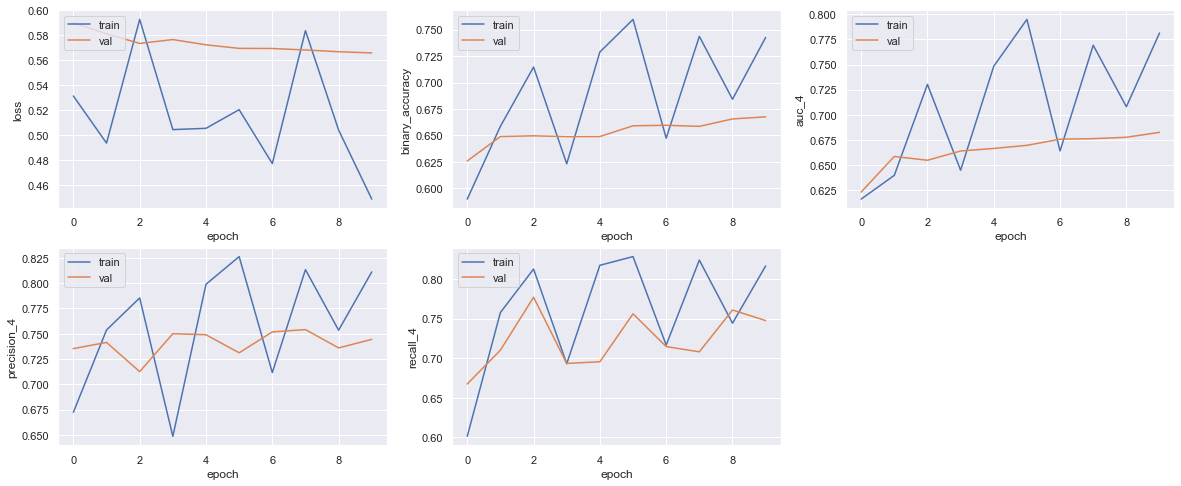

In [279]:
### BEGIN SOLUTION
plt.figure(figsize=(20, 8))
    
plt_idx = 1    
for name in hist.keys():
    if not 'val' in name:
        plt.subplot(2, 3, plt_idx)
        plt.plot(hist[name])
        plt.plot(hist['val_' + name])
        plt.ylabel(name)
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt_idx += 1

plt.show()
### END SOLUTION

### 3.5 Evaluation

Using the DKT model trained in the previous step, visually represent the AUC score obtained on the test set. What can we say about model performance? Were students' answer correctly classified? How are the results different from those of BKT and BKT+F?

First, we restore the model that has achieved the highest performance in the validation set. 

In [280]:
model.load_weights(params['best_model_weights'])

We then call the evaluate method to compute all performance metrics set up at compiling time. 

In [282]:
result = model.evaluate(test_set, verbose=params['verbose'])

27/27 [==============================] - 18s 672ms/step - loss: 0.4988 - binary_accuracy: 0.7832 - auc_4: 0.8145 - precision_4: 0.8548 - recall_4: 0.8486


We save the auc score in a variable for future re-use. 

In [283]:
auc_dkt = result[2]

#### Evaluation of the BKT and BKT+F baselines on the same train-test split

Please, remember that the comparison should be made on the same train and test sets. Therefore, we need to split the original data set according to what we have done for DKT.  

First, we identify the user ids associated to the train, validation, and test sets. 

In [326]:
### BEGIN SOLUTION
users = dataset['user_id'].unique()
test_users = users[:int(test_size * params['batch_size'])]
val_users = users[int(test_size * params['batch_size']):int((test_size+val_size) * params['batch_size'])]
train_users = users[int((test_size+val_size) * params['batch_size']):]
### END SOLUTION

In [327]:
len(test_users), len(val_users), len(train_users)

(864, 672, 2681)

We then split the original data set according to the train, validation, and test users.  

In [328]:
### BEGIN SOLUTION
bkt_train_set = dataset[dataset['user_id'].isin(train_users)]
bkt_val_set = dataset[dataset['user_id'].isin(val_users)]
bkt_test_set = dataset[dataset['user_id'].isin(test_users)]
### END SOLUTION

Finally, we fit and evaluate a traditional BKT model. 

In [ ]:
### BEGIN SOLUTION
model = Model(seed=0)
%time model.fit(data=bkt_train_set) 
auc_bkt = model.evaluate(data=bkt_test_set, metric='auc')
### END SOLUTION

... and a BKT model with forgetting. 

In [ ]:
### BEGIN SOLUTION
model = Model(seed=0)
%time model.fit(data=bkt_train_set, forgets=True) 
auck_bktf = model.evaluate(data=bkt_test_set, metric='auc')
### END SOLUTION

In [435]:
np.save('./results/dkt_comparison.npy', [auc_dkt, auc_bkt, auc_bktf])

In [436]:
auc_dkt, auc_bkt, auc_bktf = np.load('./results/dkt_comparison.npy')

#### Visualization of the performance metrics across models

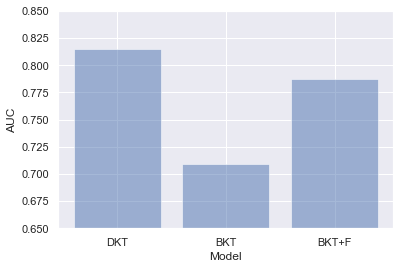

In [437]:
### BEGIN SOLUTION
labels = ['DKT', 'BKT', 'BKT+F']
scores = [auc_dkt, auc_bkt, auc_bktf]

x_pos = np.arange(len(labels))
plt.bar(x_pos, scores, align='center', alpha=0.5, ecolor='black', capsize=10)

plt.xticks(x_pos, labels)
plt.xlabel('Model')
plt.ylabel('AUC')
plt.ylim(.65, .85)

plt.show()
### END SOLUTION

### 3.6 Ablation Study



#### Backbone Network
As seen during the lecture, the recurrent neural network used as a backbone for the DKT model is represented by an LSTM. To what extent an LSTM leads to higher performance than other recurrent networks such as RNNs and GRUs? How does it change across data sets? Please, do not forget that the data and the patterns behind it may lead to different rankings among backbone networks.

In [304]:
backbone_nn_range = [tf.keras.layers.GRU, tf.keras.layers.LSTM]

In [ ]:
### BEGIN SOLUTION
aucs_dkt = []
for backbone_nn in backbone_nn_range: 
    print('Backbone NN', backbone_nn)
    params['backbone_nn'] = backbone_nn
    model = create_model(nb_features, nb_skills, params)
    model.fit(train_set, epochs=params['epochs'], steps_per_epoch=train_size, validation_data=val_set, callbacks=[ckp_callback], verbose=1)
    aucs_dkt.append(model.evaluate(test_set, verbose=params['verbose'])[2])
### END SOLUTION

In [440]:
np.save('./results/backbone_nn_range.npy', aucs_dkt)

In [442]:
aucs_dkt = np.load('./results/backbone_nn_range.npy')

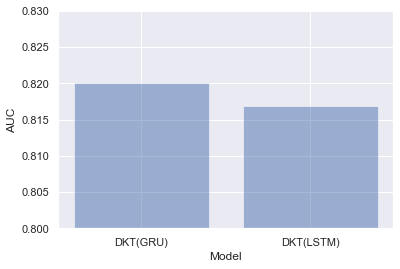

In [444]:
### BEGIN SOLUTION
labels = ['DKT({})'.format(str(b).split('.')[-1][:-2]) for b in backbone_nn_range]
scores = aucs_dkt

x_pos = np.arange(len(labels))
plt.bar(x_pos, scores, align='center', alpha=0.5, ecolor='black', capsize=10)

plt.xticks(x_pos, labels)
plt.xlabel('Model')
plt.ylabel('AUC')
plt.ylim(.80, .83)

plt.show()
### END SOLUTION

#### Number of Units
As seen during the lecture, sometimes we are interested in playing with the hyper-parameters. How do the results vary when changing the number of units for the LSTM? Which number of units makes more sense? What happens when the number of units is very small? What happens when the number of units is very large? These questions are all fundamental to deeply understand a BKT model. 

In [321]:
recurrent_units_range = [8, 16, 32, 64, 128]

In [ ]:
### BEGIN SOLUTION
aucs_dkt = []
for recurrent_units in recurrent_units_range: 
    print('Recurrent Units', recurrent_units)
    params['recurrent_units'] = recurrent_units
    model = create_model(nb_features, nb_skills, params)
    model.fit(train_set, epochs=params['epochs'], steps_per_epoch=train_size, validation_data=val_set, callbacks=[ckp_callback], verbose=1)
    aucs_dkt.append(model.evaluate(test_set, verbose=params['verbose'])[2])
### END SOLUTION

In [445]:
np.save('./results/recurrent_units_range.npy', aucs_dkt)

In [446]:
aucs_dkt = np.load('./results/recurrent_units_range.npy')

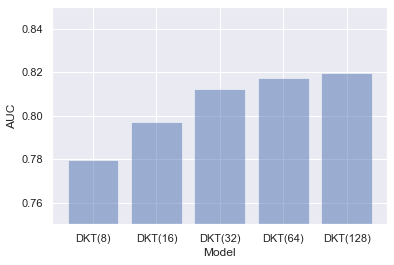

In [448]:
### BEGIN SOLUTION
labels = ['DKT({})'.format(u) for u in recurrent_units_range]
scores = aucs_dkt

x_pos = np.arange(len(labels))
plt.bar(x_pos, scores, align='center', alpha=0.5, ecolor='black', capsize=10)

plt.xticks(x_pos, labels)
plt.xlabel('Model')
plt.ylabel('AUC')
plt.ylim(.75, .85)

plt.show()
### END SOLUTION

## 4. Summary

In this tutorial, you experimented with two advanced knowledge tracing strategies, namely BKT+F and DKT. With these advanced modelling, you built and evaluated the performance of student models in correctly classifying students' answers to problems pertaining to certain skills, going beyond a couple of limitations showed by the traditional BKT. Particular focus was given to the discussion and interpretation of the results. 